In [261]:
import pandas as pd

In [262]:
path=r"C:\Users\USER\Downloads\Coffee Shop Sales.xlsx\Coffee Shop Sales.xlsx"

df=pd.read_excel(path)

df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


        계획

In [263]:
# // 날짜별 시간대별 붐비는 시간 체크
# // 평균내기
# // 귀무가설 >> 주말과 평일 거래량 평균이 같다.
# // 대립가설 >> 주말과 평일 거래량 평균이 다르다.

        시간 추출
    

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB


In [265]:
df['transaction_time']=pd.to_datetime(df['transaction_time'],format='%H:%M:%S', errors='coerce')

df['transaction_time'].head()


0   1900-01-01 07:06:11
1   1900-01-01 07:08:56
2   1900-01-01 07:14:04
3   1900-01-01 07:20:24
4   1900-01-01 07:22:41
Name: transaction_time, dtype: datetime64[ns]

In [266]:
df['hour']=df['transaction_time'].dt.hour

In [267]:
daily_hour=df.groupby(['transaction_date','hour']).size().reset_index(name='transaction_cnt')

daily_hour.head()

,transaction_date,hour,transaction_cnt
0,2023-01-01,7,17
1,2023-01-01,8,19
2,2023-01-01,9,43
3,2023-01-01,10,26
4,2023-01-01,11,51


        붐비는 시간대 시각화로 체크하기

In [268]:
import matplotlib.pyplot as plt

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages

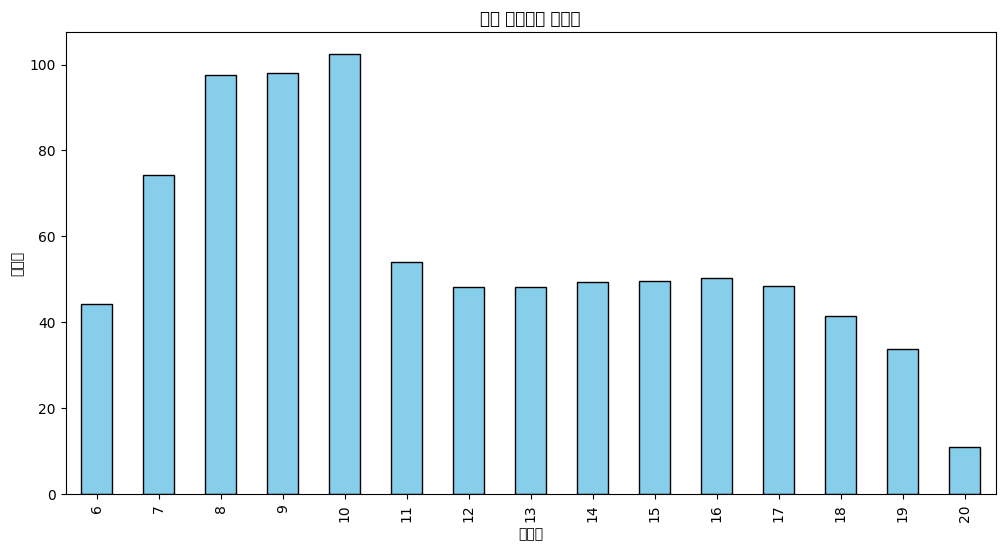

In [269]:
avg_hour=daily_hour.groupby('hour')['transaction_cnt'].mean()

plt.figure(figsize=(12,6))
avg_hour.plot(kind='bar',color='skyblue',edgecolor='black')
plt.title("평균 시간대별 거래량")
plt.xlabel("시간대")
plt.ylabel("거래량")
plt.show()

        8시부터 10시까지 peak time 확인 완료

        t-test 진행

In [270]:
import scipy.stats as stats

In [271]:
df['day_week']=df['transaction_date'].dt.dayofweek
# // dayofweek: Pandas에서 날짜의 요일을 숫자로 나타내는 속성

# df['day_week'].head()

df['weekend']=df['day_week'].apply(lambda x: 1 if x >=5 else 0)

# df['weekend'].head()

peak_hours = df[(df['hour'] >= 8) & (df['hour'] <= 10)]
daily_cnt = peak_hours.groupby(['transaction_date', 'hour', 'weekend']).size().reset_index(name='transaction_cnt')
# daily_cnt.head(30)

peak_avg = daily_cnt.groupby(['hour', 'weekend'])['transaction_cnt'].mean().reset_index()

# // 주말
weekend_=peak_avg[peak_avg['weekend']==1]['transaction_cnt']

# // 평일
weekday_=peak_avg[peak_avg['weekend']==0]['transaction_cnt']

# weekend_.head()
# weekday_.head()

        주말과 평일 비교 >> 독립 표본

In [272]:
t_stat,p_value=stats.ttest_ind(weekend_,weekday_,equal_var=False)

alpha=0.05

if p_value < alpha:
    print(f"t-stats: {t_stat:.2f}, p-value: {p_value:.2f}.\n 귀무가설 기각. 주말과 평일 평균 거래량 차이가 있습니다.")
else:
    print(f"t-stats: {t_stat:.2f}, p-value: {p_value:.2f}.\n 귀무가설 채택. 주말과 평일 평균 거래량 차이가 없습니다.")

t-stats: -0.90, p-value: 0.42.
 귀무가설 채택. 주말과 평일 평균 거래량 차이가 없습니다.


In [273]:
import seaborn as sns

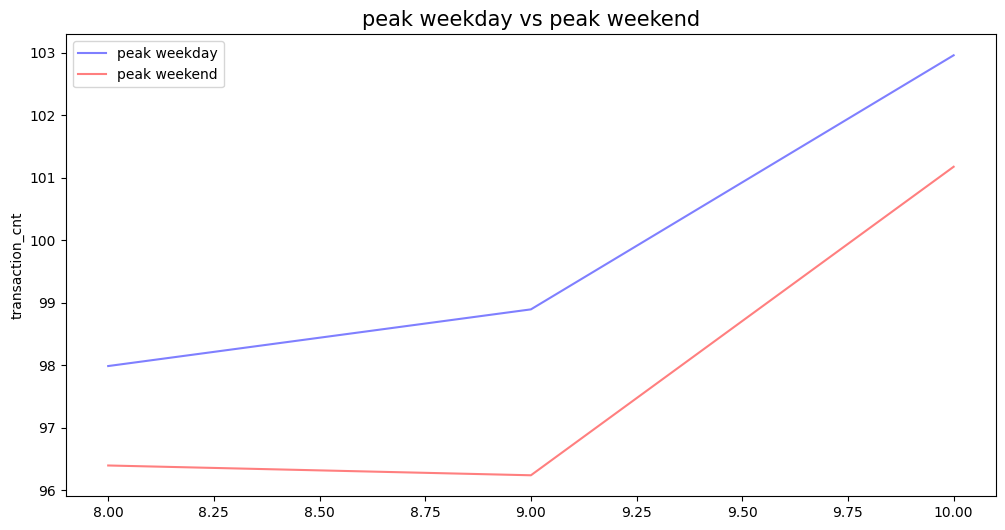

In [274]:
weekday_plot = peak_avg[peak_avg['weekend'] == 0]
weekend_plot = peak_avg[peak_avg['weekend'] == 1]

plt.figure(figsize=(12,6))
sns.lineplot(data=weekday_plot,x='hour',y='transaction_cnt',color='blue',label='peak weekday', alpha=0.5)
sns.lineplot(data=weekend_plot,x='hour',y='transaction_cnt',color='red',label='peak weekend',alpha=0.5)
plt.title("peak weekday vs peak weekend",fontsize=15)
plt.xlabel("")
plt.show()